In [1]:
import tensorflow as tf
import numpy as np
import math
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# Set random seed
np.random.seed(0)

# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print train[0]
print labels[0]

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
0


p1_size =  1296
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoc

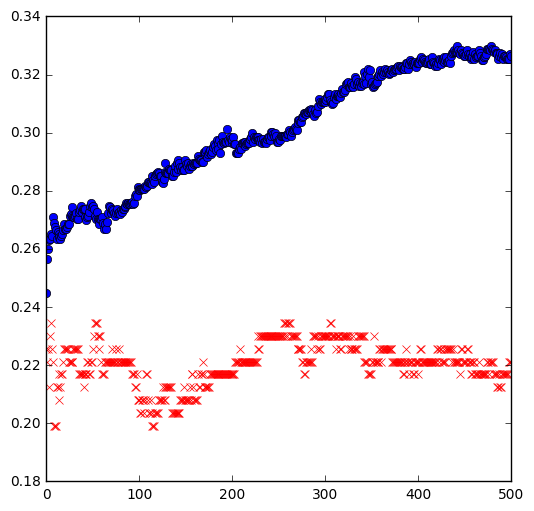

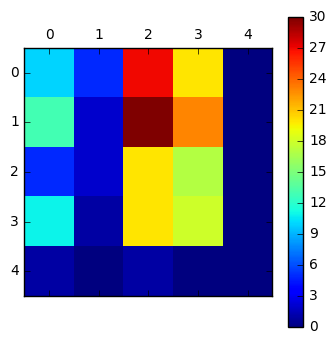

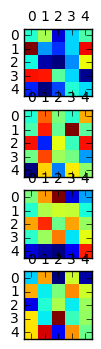

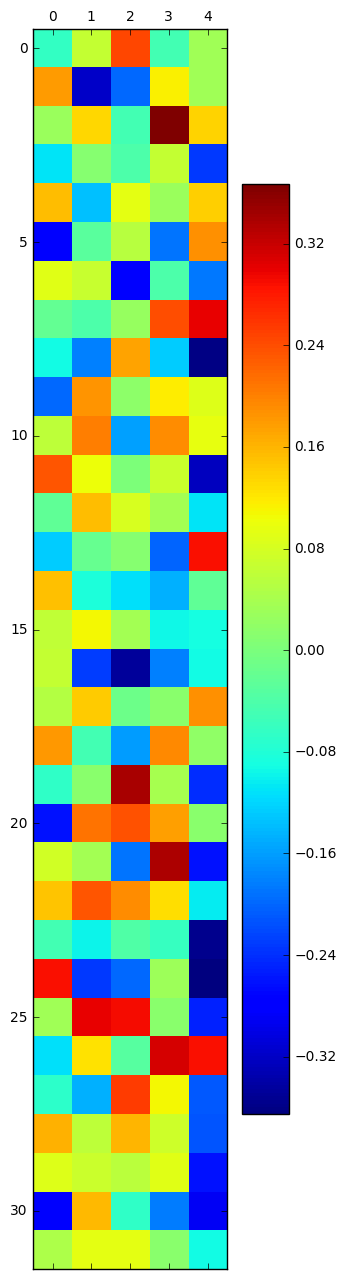

In [4]:
# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)
# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]

sess = tf.InteractiveSession()


# These will be inputs
## Input pixels, image with one channel (gray)
x = tf.placeholder("float", [None, 36, 36])
# Note that -1 is for reshaping
x_im = tf.reshape(x, [-1,36,36,1])
## Known labels
# None works during variable creation to be
# unspecified size
y_ = tf.placeholder("float", [None,5])

# Conv layer 1
num_filters = 4
winx = 5
winy = 5
W1 = tf.Variable(tf.truncated_normal(
    [winx, winy, 1 , num_filters],
    stddev=1./math.sqrt(winx*winy)))
b1 = tf.Variable(tf.constant(0.1,
                shape=[num_filters]))
# 5x5 convolution, pad with zeros on edges
xw = tf.nn.conv2d(x_im, W1,
                  strides=[1, 1, 1, 1],
                  padding='SAME')
h1 = tf.nn.relu(xw + b1)
# 2x2 Max pooling, no padding on edges
p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='VALID')

# Need to flatten convolutional output for use in dense layer
p1_size = np.product(
          [s.value for s in p1.get_shape()[1:]])
print 'p1_size = ', p1_size

p1f = tf.reshape(p1, [-1, p1_size ])

# Dense layer
num_hidden = 32
W2 = tf.Variable(tf.truncated_normal(
     [p1_size, num_hidden],
     stddev=2./math.sqrt(p1_size)))
b2 = tf.Variable(tf.constant(0.2,
     shape=[num_hidden]))
h2 = tf.nn.relu(tf.matmul(p1f,W2) + b2)

# Output Layer
W3 = tf.Variable(tf.truncated_normal(
     [num_hidden, 5],
     stddev=1./math.sqrt(num_hidden)))
b3 = tf.Variable(tf.constant(0.1,shape=[5]))

keep_prob = tf.placeholder("float")
h2_drop = tf.nn.dropout(h2, keep_prob)

# Just initialize
sess.run(tf.initialize_all_variables())

# Define model
y = tf.nn.softmax(tf.matmul(h2_drop,W3) + b3)

### End model specification, begin training code


# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(
             0.01).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),
                              tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(
           correct_prediction, "float"))

# Actually train
epochs = 5000
train_acc = np.zeros(epochs/10)
test_acc = np.zeros(epochs/10)
for i in range(epochs):
    # Record summary data, and the accuracy
    if i % 10 == 0: 
        print 'epoch: ', i/10
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train,
            y_: onehot_train, keep_prob: 1.0})
        train_acc[i/10] = A
        # And now the validation set
        A = accuracy.eval(feed_dict={x: test,
            y_: onehot_test, keep_prob: 1.0})
        test_acc[i/10] = A
    train_step.run(feed_dict={x: train,
        y_: onehot_train, keep_prob: 0.5})

# Plot the accuracy curves
plt.figure(figsize=(6, 6))
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

# Look at the final testing confusion matrix
pred = np.argmax(y.eval(
       feed_dict={x: test, keep_prob: 1.0,
       y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,
                              axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

# Let's look at a subplot of some weights
f, plts = plt.subplots(4)
for i in range(4):
    plts[i].matshow(
            W1.eval()[:,:,0,i])

# Examine the output weights
plt.matshow(W3.eval())
plt.colorbar()

In [ ]:
# Save the weights
saver = tf.train.Saver()
saver.save(sess, "conv1.ckpt")

# Restore
saver.restore(sess, "conv1.ckpt")

# Or use Numpy manually
def save_all(name = 'conv1'):
    np.savez_compressed(name, W1.eval(),
            b1.eval(), W2.eval(), b2.eval(),
            W3.eval(), b3.eval())

save_all()

def load_all(name = 'conv1.npz'):
    data = np.load(name)
    sess.run(W1.assign(data['arr_0']))
    sess.run(b1.assign(data['arr_1']))
    sess.run(W2.assign(data['arr_2']))
    sess.run(b2.assign(data['arr_3']))
    sess.run(W3.assign(data['arr_4']))
    sess.run(b3.assign(data['arr_5']))

load_all()